In [ ]:
import os, glob, warnings
warnings.filterwarnings('ignore')

import numpy as np
import librosa, librosa.display

# Optional noise reduction; set USE_NOISE_REDUCTION=True to enable
try:
    import noisereduce as nr
    _HAS_NR = True
except Exception:
    _HAS_NR = False

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, AveragePooling2D,
                                     Dense, Flatten, Dropout, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# -----------------------------
# 0) Directory scaffold (once)
# -----------------------------
def create_project_structure():
    for d in ['data/gtzan','models','results','notebooks','scripts']:
        os.makedirs(d, exist_ok=True)
create_project_structure()

# -----------------------------
# 1) Locate dataset audio path
# -----------------------------
def find_audio_files(dataset_root):
    """Find the genres folder containing the .wav files."""
    candidate_paths = [
        os.path.join(dataset_root, "genres_original"),
        os.path.join(dataset_root, "Data", "genres_original"),
        os.path.join(dataset_root, "genres"),
        dataset_root
    ]
    genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

    for p in candidate_paths:
        if os.path.isdir(p) and any(g in os.listdir(p) for g in genres):
            print(f"✅ Found audio files at: {p}")
            return p

    print("Searching recursively…")
    for root, dirs, files in os.walk(dataset_root):
        if sum(f.endswith('.wav') for f in files) >= 100:  # heuristic
            print(f"✅ Found many .wav files at: {root}")
            return root

    raise FileNotFoundError("❌ Could not find GTZAN .wav files.")

# Prefer the official Kaggle mount if available; else use kagglehub cache if you used it
default_roots = [
    "/kaggle/input/gtzan-dataset-music-genre-classification",
    os.path.expanduser("~/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification")
]
dataset_root = None
for r in default_roots:
    if os.path.exists(r):
        dataset_root = r
        break
if dataset_root is None:
    # Fallback: current working dir
    dataset_root = os.getcwd()

audio_path = find_audio_files(dataset_root)

# -----------------------------
# 2) Feature extraction
# -----------------------------
GENRES = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

def extract_logmel(
    y, sr,
    n_fft=1024, hop_length=512, n_mels=128, win='hann',
    target_seconds=30.0, use_trim=True, use_noise_reduction=False
):
    """
    Returns log-mel spectrogram (dB), shape [n_mels, T_fixed]
    """
    if use_trim:
        y, _ = librosa.effects.trim(y, top_db=20)

    # pad/clip to target duration for consistency
    target_len = int(target_seconds * sr)
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)))
    else:
        y = y[:target_len]

    if use_noise_reduction and _HAS_NR:
        noise = y[: int(0.5 * sr)]
        y = nr.reduce_noise(y=y, y_noise=noise, sr=sr, prop_decrease=1.0)

    # normalize peak to avoid scale issues
    peak = np.max(np.abs(y))
    if peak > 0:
        y = 0.99 * y / peak

    m = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, window=win
    )
    m_db = librosa.power_to_db(m, ref=np.max)

    # compute target width analytically (~ (#frames) ≈ 1 + floor((N - n_fft)/hop))
    T_fixed = 1 + (len(y) - n_fft) // hop_length
    if m_db.shape[1] < T_fixed:
        pad = T_fixed - m_db.shape[1]
        m_db = np.pad(m_db, ((0,0),(0,pad)), mode='constant')
    else:
        m_db = m_db[:, :T_fixed]

    return m_db

def load_gtzan_from_path(audio_path, max_files_per_genre=100,
                         sr=22050, n_fft=1024, hop_length=512, n_mels=128,
                         use_trim=True, use_noise_reduction=False):
    """
    Loads GTZAN, extracts log-mel features, returns X [N, n_mels, T, 1] and labels y (str list).
    """
    items = os.listdir(audio_path)
    available_genres = [g for g in GENRES if os.path.isdir(os.path.join(audio_path, g))]
    if not available_genres:
        # search one level deeper
        for sub in items:
            sp = os.path.join(audio_path, sub)
            if os.path.isdir(sp):
                sub_items = os.listdir(sp)
                tmp = [g for g in GENRES if g in sub_items]
                if tmp:
                    audio_path = sp
                    available_genres = tmp
                    break
    if not available_genres:
        raise RuntimeError("No genre folders found under audio_path.")

    print(f"\nLoading features from: {audio_path}")
    for g in GENRES:
        p = os.path.join(audio_path, g)
        msg = f"{g:10s}: "
        if os.path.isdir(p):
            msg += f"{len(glob.glob(os.path.join(p,'*.wav')))} files"
        else:
            msg += "⚠️ missing"
        print(msg)

    X, y = [], []
    for g in available_genres:
        files = sorted(glob.glob(os.path.join(audio_path, g, "*.wav")))[:max_files_per_genre]
        print(f"\n→ {g}: {len(files)} files")
        for fp in tqdm(files, desc=g):
            try:
                audio, _ = librosa.load(fp, sr=sr, mono=True)
                m_db = extract_logmel(
                    audio, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels,
                    use_trim=use_trim, use_noise_reduction=use_noise_reduction
                )
                X.append(m_db.astype(np.float32))
                y.append(g)
            except Exception as e:
                print(f"   Skip {os.path.basename(fp)}: {e}")

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=object)
    # add channel dim
    X = X[..., np.newaxis]
    print(f"\n✅ Loaded: X={X.shape} (N, {n_mels}, T, 1), y={y.shape}")
    return X, y

# ---- Run extraction (set noise reduction as you like) ----
X, y = load_gtzan_from_path(
    audio_path,
    max_files_per_genre=100,   # up to 100 per genre (GTZAN has 100/genre)
    sr=22050,
    n_fft=1024,
    hop_length=512,
    n_mels=128,
    use_trim=True,
    use_noise_reduction=False   # set True if you want (slower)
)

# -----------------------------
# 3) Encode labels & split
# -----------------------------
le = LabelEncoder()
y_int = le.fit_transform(y)
num_classes = len(le.classes_)
print("Classes:", list(le.classes_))

# Proper stratify: use integer labels (NOT one-hot)
X_train, X_test, y_train_int, y_test_int = train_test_split(
    X, y_int, test_size=0.3, random_state=42, stratify=y_int
)

# One-hot for training
y_train = tf.keras.utils.to_categorical(y_train_int, num_classes=num_classes)
y_test  = tf.keras.utils.to_categorical(y_test_int,  num_classes=num_classes)

# -----------------------------
# 4) Normalization
# -----------------------------
# Log-mels are in dB (<= 0). Map each sample to [0,1] using per-sample min/max for stability.
def minmax01(arr):
    a_min = arr.min()
    a_max = arr.max()
    if a_max > a_min:
        return (arr - a_min) / (a_max - a_min)
    return np.zeros_like(arr)

X_train = np.array([minmax01(x) for x in X_train], dtype=np.float32)
X_test  = np.array([minmax01(x) for x in X_test ], dtype=np.float32)

print("Shapes after split/normalize:",
      X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# -----------------------------
# 5) Model definition (compact CNN)
# -----------------------------
def build_cnn(input_shape, num_classes):
    """
    A memory-efficient CNN that progressively downsamples the (time) axis.
    """
    model = Sequential([
        # Block 1
        Conv2D(16, (3,3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        # Block 2
        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        # Block 3
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        # Block 4
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        AveragePooling2D((2,2)),

        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = X_train.shape[1:]  # (128, T, 1)
model = build_cnn(input_shape, num_classes)
model.summary()

# -----------------------------
# 6) Training
# -----------------------------
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    ModelCheckpoint('models/best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=16,       # smaller batch helps with long time axes
    callbacks=callbacks,
    verbose=1
)

print("✅ Training complete. Best model -> models/best_model.h5")

# -----------------------------
# 7) Evaluation
# -----------------------------
y_pred_probs = model.predict(X_test)
y_pred_int = np.argmax(y_pred_probs, axis=1)

acc = accuracy_score(y_test_int, y_pred_int)
print(f"\nTest Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test_int, y_pred_int, target_names=list(le.classes_)))

print("Confusion Matrix:")
print(confusion_matrix(y_test_int, y_pred_int))


✅ Found audio files at: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original

Loading features from: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original
blues     : 100 files
classical : 100 files
country   : 100 files
disco     : 100 files
hiphop    : 100 files
jazz      : 100 files
metal     : 100 files
pop       : 100 files
reggae    : 100 files
rock      : 100 files

→ blues: 100 files


blues: 100%|██████████| 100/100 [00:05<00:00, 19.89it/s]



→ classical: 100 files


classical: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]



→ country: 100 files


country: 100%|██████████| 100/100 [00:03<00:00, 28.88it/s]



→ disco: 100 files


disco: 100%|██████████| 100/100 [00:04<00:00, 20.34it/s]



→ hiphop: 100 files


hiphop: 100%|██████████| 100/100 [00:03<00:00, 27.87it/s]



→ jazz: 100 files


jazz:  61%|██████    | 61/100 [00:02<00:01, 21.82it/s]

   Skip jazz.00054.wav: 


jazz: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]



→ metal: 100 files


metal: 100%|██████████| 100/100 [00:04<00:00, 20.45it/s]



→ pop: 100 files


pop: 100%|██████████| 100/100 [00:03<00:00, 28.87it/s]



→ reggae: 100 files


reggae: 100%|██████████| 100/100 [00:03<00:00, 28.41it/s]



→ rock: 100 files


rock: 100%|██████████| 100/100 [00:04<00:00, 22.29it/s]



✅ Loaded: X=(999, 128, 1290, 1) (N, 128, T, 1), y=(999,)
Classes: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Shapes after split/normalize: (699, 128, 1290, 1) (699, 10) (300, 128, 1290, 1) (300, 10)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 1290, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 1290, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 645, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 645, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 645, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 322, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 322, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 322, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 161, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 161, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 161, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 8, 80, 128)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 80, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 81920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,485,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,585,290 (40.38 MB)

 Trainable params: 10,584,810 (40.38 MB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.2089 - loss: 7.0210
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to models/best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 435ms/step - accuracy: 0.2096 - loss: 6.9575 - val_accuracy: 0.1000 - val_loss: 16.8369 - learning_rate: 0.0010
Epoch 2/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2176 - loss: 2.2486
Epoch 2: val_accuracy did not improve from 0.10000
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2178 - loss: 2.2471 - val_accuracy: 0.1000 - val_loss: 29.8445 - learning_rate: 0.0010
Epoch 3/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3273 - loss: 1.9680
Epoch 3: val_accuracy improved from 0.10000 to 0.13000, saving model to models/best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.3259 - loss: 1.9699 - val_accuracy: 0.1300 - val_loss: 47.9839 - learning_rate: 0.0010
Epoch 4/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2872 - loss: 1.8893
Epoch 4: val_accuracy improved from 0.13000 to 0.15667, saving model to models/best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.2881 - loss: 1.8894 - val_accuracy: 0.1567 - val_loss: 45.3717 - learning_rate: 0.0010
Epoch 5/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3249 - loss: 1.9670
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_accuracy did not improve from 0.15667
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.3252 - loss: 1.9656 - val_accuracy: 0.1167 - val_loss: 65.2517 - learning_rate: 0.0010
Epoch 6/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3377 - loss: 1.8401
Epoch 6: val_accuracy did not improve from 0.15667
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.3382 - loss: 1.8408 - val_accuracy: 0.1267 - val_loss: 70.8016 - learning_rate: 5.0000e-04
Epoch 7/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4080 - loss: 1.6498
Epoch 7: val_accuracy did not improve from 0.15667
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.4093 - loss: 1.6460 - val_accuracy

44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.5333 - loss: 1.3979 - val_accuracy: 0.1833 - val_loss: 16.0063 - learning_rate: 2.5000e-04
Epoch 11/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6160 - loss: 1.1610
Epoch 11: val_accuracy improved from 0.18333 to 0.29000, saving model to models/best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.6162 - loss: 1.1591 - val_accuracy: 0.2900 - val_loss: 11.0817 - learning_rate: 2.5000e-04
Epoch 12/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6068 - loss: 1.0139
Epoch 12: val_accuracy did not improve from 0.29000
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.6077 - loss: 1.0127 - val_accuracy: 0.2600 - val_loss: 8.3173 - learning_rate: 2.5000e-04
Epoch 13/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6471 - loss: 0.9098
Epoch 13: val_accuracy improved from 0.29000 to 0.36333, saving model to models/best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.6481 - loss: 0.9100 - val_accuracy: 0.3633 - val_loss: 7.7750 - learning_rate: 2.5000e-04
Epoch 14/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7248 - loss: 0.8341
Epoch 14: val_accuracy improved from 0.36333 to 0.47667, saving model to models/best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.7243 - loss: 0.8334 - val_accuracy: 0.4767 - val_loss: 2.6587 - learning_rate: 2.5000e-04
Epoch 15/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7355 - loss: 0.7649
Epoch 15: val_accuracy improved from 0.47667 to 0.50667, saving model to models/best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.7358 - loss: 0.7617 - val_accuracy: 0.5067 - val_loss: 2.6535 - learning_rate: 2.5000e-04
Epoch 16/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8125 - loss: 0.5269
Epoch 16: val_accuracy improved from 0.50667 to 0.54667, saving model to models/best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.8125 - loss: 0.5259 - val_accuracy: 0.5467 - val_loss: 2.2527 - learning_rate: 2.5000e-04
Epoch 17/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8156 - loss: 0.4533
Epoch 17: val_accuracy improved from 0.54667 to 0.58667, saving model to models/best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.8166 - loss: 0.4526 - val_accuracy: 0.5867 - val_loss: 2.0697 - learning_rate: 2.5000e-04
Epoch 18/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8760 - loss: 0.3692
Epoch 18: val_accuracy improved from 0.58667 to 0.61000, saving model to models/best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.8752 - loss: 0.3707 - val_accuracy: 0.6100 - val_loss: 1.5891 - learning_rate: 2.5000e-04
Epoch 19/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8741 - loss: 0.3748
Epoch 19: val_accuracy improved from 0.61000 to 0.62667, saving model to models/best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.8739 - loss: 0.3735 - val_accuracy: 0.6267 - val_loss: 1.9547 - learning_rate: 2.5000e-04
Epoch 20/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8880 - loss: 0.3354
Epoch 20: val_accuracy did not improve from 0.62667
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8882 - loss: 0.3337 - val_accuracy: 0.5667 - val_loss: 2.0637 - learning_rate: 2.5000e-04
Epoch 21/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8996 - loss: 0.2727
Epoch 21: val_accuracy improved from 0.62667 to 0.65333, saving model to models/best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9000 - loss: 0.2721 - val_accuracy: 0.6533 - val_loss: 1.8245 - learning_rate: 2.5000e-04
Epoch 22/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9233 - loss: 0.2093
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 22: val_accuracy improved from 0.65333 to 0.66667, saving model to models/best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9235 - loss: 0.2087 - val_accuracy: 0.6667 - val_loss: 1.6506 - learning_rate: 2.5000e-04
Epoch 23/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9350 - loss: 0.1962
Epoch 23: val_accuracy improved from 0.66667 to 0.70000, saving model to models/best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9355 - loss: 0.1951 - val_accuracy: 0.7000 - val_loss: 1.3499 - learning_rate: 1.2500e-04
Epoch 24/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9466 - loss: 0.1287
Epoch 24: val_accuracy improved from 0.70000 to 0.70333, saving model to models/best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9463 - loss: 0.1301 - val_accuracy: 0.7033 - val_loss: 1.6834 - learning_rate: 1.2500e-04
Epoch 25/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9711 - loss: 0.0853
Epoch 25: val_accuracy improved from 0.70333 to 0.74333, saving model to models/best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9709 - loss: 0.0855 - val_accuracy: 0.7433 - val_loss: 1.4772 - learning_rate: 1.2500e-04
Epoch 26/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9441 - loss: 0.2056
Epoch 26: val_accuracy improved from 0.74333 to 0.75000, saving model to models/best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9445 - loss: 0.2028 - val_accuracy: 0.7500 - val_loss: 1.3418 - learning_rate: 1.2500e-04
Epoch 27/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9562 - loss: 0.1468
Epoch 27: val_accuracy did not improve from 0.75000
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9560 - loss: 0.1469 - val_accuracy: 0.7033 - val_loss: 1.6720 - learning_rate: 1.2500e-04
Epoch 28/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9421 - loss: 0.1261
Epoch 28: val_accuracy did not improve from 0.75000
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9427 - loss: 0.1254 - val_accuracy: 0.7367 - val_loss: 1.5549 - learning_rate: 1.2500e-04
Epoch 29/40
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9820 - loss: 0.0706
Epoch 29: val_accuracy did not improve from 0.75000
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9812 - loss: 0.0726 - val_accuracy: 0.6867 - val_loss: 1.5451 - learning_rate: 1.2500e-04
Epoch 30/4

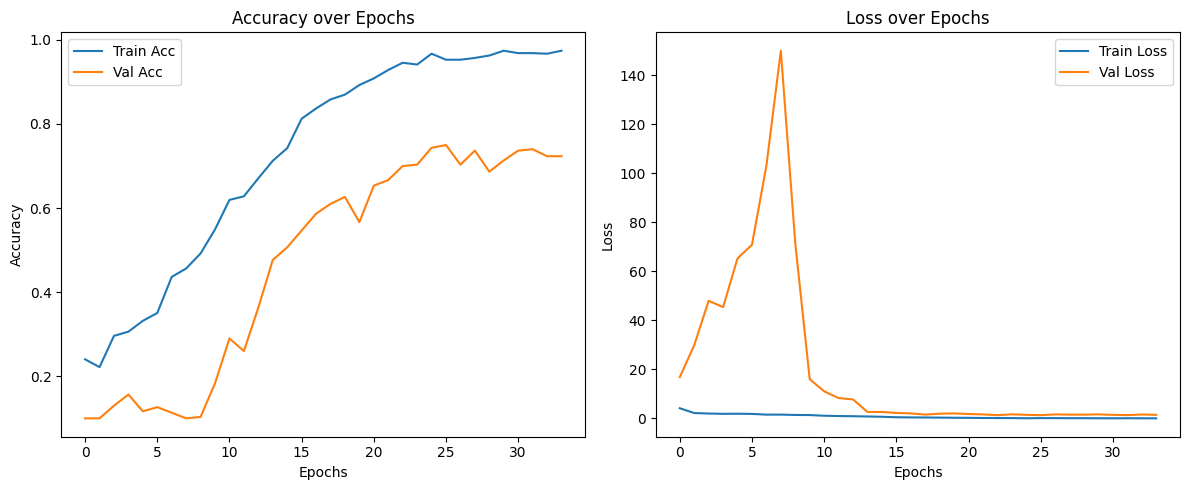

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    """Plot accuracy and loss curves from Keras history."""
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history)
